# Projeto 8: Regressão carros usados

## Etapa 1: Importação das bibliotecas

In [1]:
!pip install torch==1.4.0

     |████████████████████████████████| 753.4MB 15kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
torch.__version__

'1.4.0'

## Etapa 2: Base de dados

In [3]:
np.random.seed(123)
torch.manual_seed(123)

In [4]:
df = pd.read_csv('/content/autos.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df.drop(['dateCrawled', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen'], axis = 1, inplace = True)

In [7]:
df.head()

,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


In [8]:
df['name'].value_counts()

Ford_Fiesta                                                    657
BMW_318i                                                       627
Opel_Corsa                                                     622
Volkswagen_Golf_1.4                                            603
BMW_316i                                                       523
                                                              ... 
Mitsubishi_Carisma_1600_BJ_98_157tkm                             1
Fiat_Doblo_1.3_Multijet_16V_DPF_Parktronic                       1
Mercedes_Benz_Originalcabriolet__220_SE__W111                    1
Volkswagen_Passat_Variant_BMT_gr.Navi_LED_Xenon_Panorama_..      1
Nissan_Almera___Zuverlaessiges_Auto_fuer_kleines_Budget          1
Name: name, Length: 233531, dtype: int64

In [9]:
df.drop('name', axis=1, inplace=True)

In [10]:
df['seller'].value_counts()

privat        371525
gewerblich         3
Name: seller, dtype: int64

In [11]:
df.drop('seller', axis=1, inplace = True)

In [12]:
df['offerType'].value_counts()

Angebot    371516
Gesuch         12
Name: offerType, dtype: int64

In [13]:
df.drop('offerType', axis=1, inplace = True)

In [14]:
df.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


In [15]:
df.loc[df.price <= 100].shape

(14352, 12)

In [16]:
df.loc[df.price <= 100][['price','notRepairedDamage']].value_counts()

price  notRepairedDamage
0      nein                 3483
       ja                   2005
100    ja                    399
1      nein                  307
       ja                    247
                            ... 
16     nein                    1
47     ja                      1
45     ja                      1
29     ja                      1
12     ja                      1
Length: 66, dtype: int64

In [17]:
df.drop(df.loc[df.price <= 100].index, axis=0, inplace = True)

In [18]:
df.shape

(357176, 12)

In [19]:
df.loc[df.price > 350000]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
1846,579000,control,coupe,1980,manuell,277,andere,20000,12,benzin,bmw,nein
10649,420000,control,coupe,2004,manuell,483,911,50000,4,benzin,porsche,nein
14663,11111111,control,coupe,2003,manuell,64,polo,150000,2,benzin,volkswagen,NaN
16889,1000000,control,kombi,1998,NaN,0,mondeo,150000,0,benzin,ford,ja
20143,1250000,test,coupe,2016,manuell,500,911,5000,3,benzin,porsche,nein
...,...,...,...,...,...,...,...,...,...,...,...,...
364171,3890000,test,coupe,2006,NaN,799,NaN,5000,7,NaN,sonstige_autos,nein
365461,599000,control,coupe,1980,manuell,377,andere,5000,3,benzin,bmw,nein
366653,99999999,control,cabrio,1996,manuell,192,3er,150000,0,NaN,bmw,NaN
366861,3895000,test,coupe,2006,NaN,799,NaN,5000,4,benzin,sonstige_autos,nein


In [20]:
df.drop(df.loc[df.price > 350000].index, axis=0, inplace = True)

In [21]:
df.shape

(357061, 12)

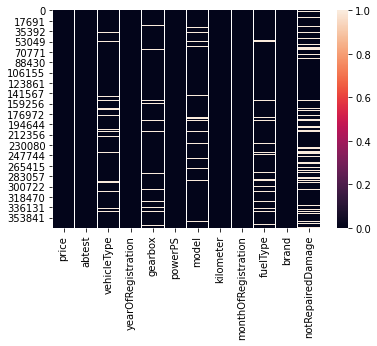

In [22]:
sns.heatmap(df.isnull());

In [23]:
df.loc[pd.isnull(df['vehicleType'])]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
16,300,test,NaN,2016,NaN,60,polo,150000,0,benzin,volkswagen,NaN
22,2900,test,NaN,2018,manuell,90,meriva,150000,5,benzin,opel,nein
26,5555,control,NaN,2017,manuell,125,c4,125000,4,NaN,citroen,nein
31,899,control,NaN,2016,manuell,60,clio,150000,6,benzin,renault,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
371495,180,control,NaN,1995,NaN,0,NaN,125000,3,benzin,opel,NaN
371504,2600,control,NaN,2005,automatik,0,c_klasse,150000,9,NaN,mercedes_benz,NaN
371509,1900,test,NaN,2000,manuell,110,NaN,150000,7,NaN,volkswagen,nein
371519,5250,control,NaN,2016,automatik,150,159,150000,12,NaN,alfa_romeo,nein


In [24]:
df['vehicleType'].value_counts()

limousine     93390
kleinwagen    77215
kombi         65771
bus           29677
cabrio        22493
coupe         18347
suv           14467
andere         3105
Name: vehicleType, dtype: int64

In [25]:
df.loc[pd.isnull(df['gearbox'])]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
15,450,test,kleinwagen,1910,NaN,0,ka,5000,0,benzin,ford,NaN
16,300,test,NaN,2016,NaN,60,polo,150000,0,benzin,volkswagen,NaN
32,245,test,limousine,1994,NaN,0,golf,150000,2,benzin,volkswagen,nein
37,1500,test,NaN,2016,NaN,0,kangoo,150000,1,diesel,renault,nein
70,1200,test,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
371443,3300,control,kombi,2006,NaN,0,touran,150000,7,diesel,volkswagen,NaN
371460,3500,control,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN
371486,350,control,kleinwagen,1996,NaN,65,punto,150000,0,NaN,fiat,NaN
371495,180,control,NaN,1995,NaN,0,NaN,125000,3,benzin,opel,NaN


In [26]:
df['gearbox'].value_counts()

manuell      265214
automatik     75427
Name: gearbox, dtype: int64

In [27]:
df.loc[pd.isnull(df['model'])]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
1,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
83,350,control,kleinwagen,1997,manuell,54,NaN,150000,3,NaN,fiat,ja
139,1450,control,limousine,1992,manuell,136,NaN,150000,0,NaN,audi,nein
156,6799,control,kleinwagen,2009,NaN,60,NaN,20000,5,benzin,volkswagen,nein
165,500,control,kleinwagen,1999,manuell,0,NaN,150000,0,benzin,renault,nein
...,...,...,...,...,...,...,...,...,...,...,...,...
371399,560,control,kleinwagen,2001,automatik,170,NaN,90000,0,benzin,fiat,ja
371476,9400,control,kombi,2007,manuell,200,NaN,150000,4,diesel,sonstige_autos,ja
371495,180,control,NaN,1995,NaN,0,NaN,125000,3,benzin,opel,NaN
371509,1900,test,NaN,2000,manuell,110,NaN,150000,7,NaN,volkswagen,nein


In [28]:
df['model'].value_counts()

golf               28821
andere             25402
3er                19865
polo               12440
corsa              11933
                   ...  
serie_2                8
rangerover             6
serie_3                3
discovery_sport        1
serie_1                1
Name: model, Length: 251, dtype: int64

In [29]:
df.loc[pd.isnull(df['fuelType'])]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
9,999,test,kleinwagen,1998,manuell,101,golf,150000,0,NaN,volkswagen,NaN
13,2500,control,kombi,2004,manuell,131,passat,150000,2,NaN,volkswagen,nein
26,5555,control,NaN,2017,manuell,125,c4,125000,4,NaN,citroen,nein
36,1600,control,andere,1991,manuell,75,kadett,70000,0,NaN,opel,NaN
41,7500,control,limousine,2002,automatik,306,e_klasse,150000,4,NaN,mercedes_benz,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
371496,3850,test,cabrio,2006,manuell,108,2_reihe,125000,2,NaN,peugeot,nein
371504,2600,control,NaN,2005,automatik,0,c_klasse,150000,9,NaN,mercedes_benz,NaN
371509,1900,test,NaN,2000,manuell,110,NaN,150000,7,NaN,volkswagen,nein
371519,5250,control,NaN,2016,automatik,150,159,150000,12,NaN,alfa_romeo,nein


In [30]:
df['fuelType'].value_counts()

benzin     216380
diesel     105923
lpg          5221
cng           555
hybrid        271
andere        157
elektro       100
Name: fuelType, dtype: int64

In [31]:
df.loc[pd.isnull(df['notRepairedDamage'])]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
8,14500,control,bus,2014,manuell,125,c_max,30000,8,benzin,ford,NaN
9,999,test,kleinwagen,1998,manuell,101,golf,150000,0,NaN,volkswagen,NaN
12,999,control,kombi,1995,manuell,115,passat,150000,11,benzin,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
371507,5999,test,kombi,2005,manuell,140,a4,150000,4,diesel,audi,NaN
371514,999,control,cabrio,2000,manuell,95,megane,150000,4,benzin,renault,NaN
371515,1690,test,kombi,2004,manuell,55,fabia,150000,4,benzin,skoda,NaN
371523,2200,test,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN


In [32]:
df['notRepairedDamage'].value_counts()

nein    259019
ja       33315
Name: notRepairedDamage, dtype: int64

In [33]:
df.loc[pd.isnull(df['price'])]

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage


In [34]:
values = {'vehicleType':'limousine', 'gearbox':'manuell', 'model':'golf',
          'fuelType':'benzin', 'notRepairedDamage':'nein'}

In [35]:
df.fillna(value=values, inplace=True)

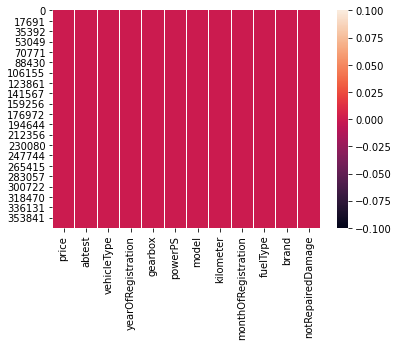

In [36]:
sns.heatmap(df.isnull());

In [37]:
X = df.iloc[:, 1:13].values
y = df.iloc[:, 0].values
X.shape, y.shape

((357061, 11), (357061,))

In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [39]:
onehot = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(),
                                          [0,1,3,5,8,9,10])],
                                          remainder='passthrough')

In [40]:
X = onehot.fit_transform(X).toarray()
X.shape

(357061, 316)

In [41]:
X[0]

array([0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

In [42]:
type(X)

numpy.ndarray

In [43]:
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).view(-1,1)

In [44]:
type(X), y.shape

(torch.Tensor, torch.Size([357061, 1]))

## Etapa 3: Construção do modelo

In [45]:
# 316 -> 158 -> 158 -> 1
# (entradas + saídas) / 2 = (316 + 1) / 2
reg = nn.Sequential(nn.Linear(316, 158),
                    nn.ReLU(),
                    nn.Linear(158, 158),
                    nn.ReLU(),
                    nn.Linear(158, 1))

criterion = nn.L1Loss()
optimizer = optim.Adam(reg.parameters())

In [51]:
dataset = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=300, shuffle=True)

## Etapa 4: Treinamento do modelo

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [53]:
reg.to(device)

Sequential(
  (0): Linear(in_features=316, out_features=158, bias=True)
  (1): ReLU()
  (2): Linear(in_features=158, out_features=158, bias=True)
  (3): ReLU()
  (4): Linear(in_features=158, out_features=1, bias=True)
)

In [55]:
for epoch in range(100):
  running_loss = 0.
  running_mae = 0.

  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = reg.forward(inputs)

    mae = F.l1_loss(outputs, labels).item()
    running_mae += mae

    loss =  criterion(outputs, labels)
    loss.backward()

    optimizer.step()
    running_loss += loss.item()

    print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:06.2f} - MAE {:06.2f}'\
          .format(epoch+1, i+1, len(y)//300, loss, mae))
  
  print('ÉPOCA {:3d} finalizada: perda {:0.5f} - MAE {:0.5f}'\
        .format(epoch+1, running_loss/len(train_loader), running_mae/len(train_loader)))

Streaming output truncated to the last 5000 lines.
  96 - Loop 961 de 1190: perda 2579.15 - MAE 2579.15
  96 - Loop 962 de 1190: perda 2046.87 - MAE 2046.87
  96 - Loop 963 de 1190: perda 2240.92 - MAE 2240.92
  96 - Loop 964 de 1190: perda 2579.71 - MAE 2579.71
  96 - Loop 965 de 1190: perda 2715.78 - MAE 2715.78
  96 - Loop 966 de 1190: perda 2143.95 - MAE 2143.95
  96 - Loop 967 de 1190: perda 1868.32 - MAE 1868.32
  96 - Loop 968 de 1190: perda 1992.71 - MAE 1992.71
  96 - Loop 969 de 1190: perda 2270.92 - MAE 2270.92
  96 - Loop 970 de 1190: perda 1925.83 - MAE 1925.83
  96 - Loop 971 de 1190: perda 1839.21 - MAE 1839.21
  96 - Loop 972 de 1190: perda 2742.70 - MAE 2742.70
  96 - Loop 973 de 1190: perda 2110.23 - MAE 2110.23
  96 - Loop 974 de 1190: perda 1936.14 - MAE 1936.14
  96 - Loop 975 de 1190: perda 2084.26 - MAE 2084.26
  96 - Loop 976 de 1190: perda 2167.53 - MAE 2167.53
  96 - Loop 977 de 1190: perda 2003.49 - MAE 2003.49
  96 - Loop 978 de 1190: perda 2541.61 - MAE 254

## Etapa 5: Avaliação do modelo

In [56]:
reg.eval()

Sequential(
  (0): Linear(in_features=316, out_features=158, bias=True)
  (1): ReLU()
  (2): Linear(in_features=158, out_features=158, bias=True)
  (3): ReLU()
  (4): Linear(in_features=158, out_features=1, bias=True)
)

In [57]:
previsoes = reg.forward(X.to(device))

In [58]:
previsoes

tensor([[  523.1838],
        [ 8259.4385],
        [10683.4268],
        ...,
        [ 4642.2676],
        [ 2261.0188],
        [24382.0762]], device='cuda:0', grad_fn=<AddmmBackward>)

In [59]:
y

tensor([[  480.],
        [18300.],
        [ 9800.],
        ...,
        [ 9200.],
        [ 3400.],
        [28990.]])

In [60]:
y.mean()

tensor(5957.3027)

In [61]:
previsoes.mean()

tensor(4165.4917, device='cuda:0', grad_fn=<MeanBackward0>)

In [62]:
y.mean() - previsoes.mean()

tensor(1791.8110, grad_fn=<SubBackward0>)